In [1]:
import os
from utils.configuration import *

In [2]:
experiment_name = "ordinal_vars_test"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'continous',
            'x3':'continous',
            't1':'ordinal_Xc_Yo',
            't2':'ordinal_Xc_Yo',
            'x5':'continous',
            'x6':'continous',
            'y':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
t1                   | ordinal_Xc_Yo   | continuous [c]                 | ordinal    [0,…,K]            
t2                   | ordinal_Xc_Yo   | continuous [c]                 | ordinal    [0,…,K]            
x5                   | continous       | continuous [c]  

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


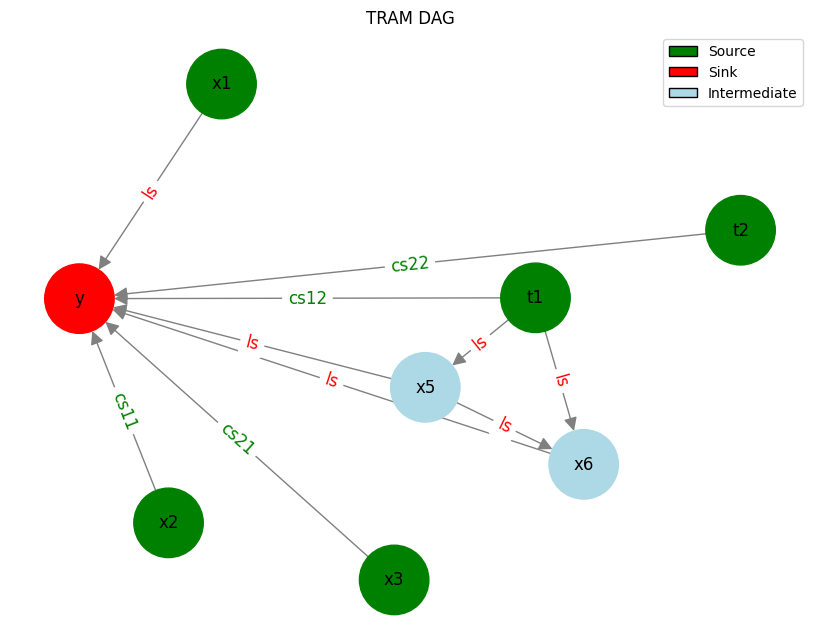

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

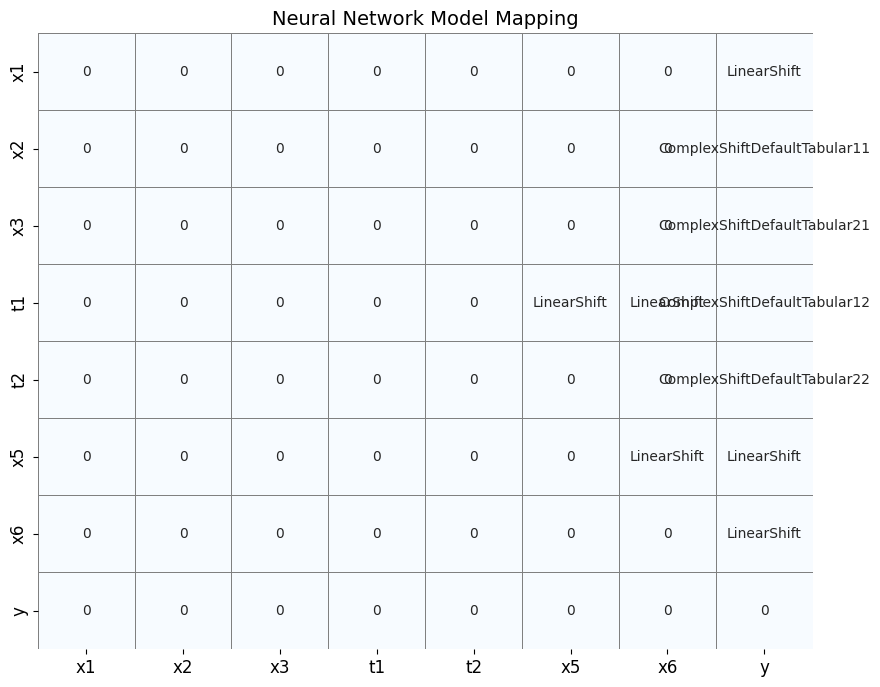

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.special import logit

df = pd.DataFrame(
    make_blobs(n_samples=10_000, centers=8, n_features=8, random_state=13)[0],
    columns=['x1','x2','x3','x5','t1','t2','x6','y']
)


df['t1'] = (df['t1'] > df['t1'].median()).astype(int)
df['t2']=df['t1'].copy()
print(df.head())
df.info()


         x1         x2        x3        x5  t1  t2        x6         y
0  3.758992  -1.131220 -0.095220  9.899652   0   0  3.906152 -3.767058
1 -8.768500 -10.650421  2.893708  9.475817   0   0  7.026890 -8.332300
2  9.450577   5.692370 -3.912306  0.038899   1   1  5.710581 -2.963938
3  3.996866   4.773048 -9.309254 -4.166017   0   0 -2.438505  2.368463
4  2.789833   4.072897 -8.760611 -2.006136   0   0 -2.966617  2.577728
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   x5      10000 non-null  float64
 4   t1      10000 non-null  int64  
 5   t2      10000 non-null  int64  
 6   x6      10000 non-null  float64
 7   y       10000 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 625.1 KB


In [8]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [9]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [10]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=True,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': True, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':              x1        x2         x3        x5  t1  t2        x6         y
9254   5.790936 -7.249819   6.229806  6.689151   1   1  1.649284  6.730776
1561   2.400405  4.557155  -9.872843 -6.638451   0   0 -1.641476  2.115917
1670  -9.930820 -9.865590   1.492166  6.758005   0   0  5.124343 -7.871000
6087   4.827056 -5.193179   5.285507  9.157148   1   1  1.794985  7.551717
6669   6.572506 -4.023019   5.458759  9.673777   1   1  0.357335  5.307645
...         ...       ...        ...       ...  ..  ..       ...       ...
5734  10.089638  3.268733  -6.138526  1.147616   1   1  4.632081 -1.416370
5191   8.794295  3.537923  -5.136052  1.756384   1   1  7.567315 -1.000883
5390  -4.647563  2.710111  10.264334 -6.417286   1   1 -2.431899  3.603696
860   -8.692852 -8.695716   1.769343  5.199065   0   0  6.421811

In [11]:
td_model.fit(train_df, val_df,
             epochs=1000,batch_size=1_000,
             verbose=False,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "parallel")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[WARNING] 'num_workers' is ignored in parallel mode (disabled to prevent nested multiprocessing).
[WARNING] 'persistent_workers' is ignored in parallel mode (disabled to prevent nested multiprocessing).
[WARNING] 'prefetch_factor' is ignored in parallel mode (disabled to prevent nested multiprocessing).


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.7s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.8s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    3.8s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished


In [14]:
samples, latents = td_model.sample(debug=False)#,do_interventions ={'x1':1.0,'t1':1.0,'t2':1.0})

Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x6/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 208.55it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 225.41it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 208.27it/s]


----*----------*-------------*--------Sample Node: t1 ------------*-----------------*-------------------*--
[WARNING] target_col 't1' not in DataFrame columns — is this intended to be used as a Sampler?



----*----------*-------------*--------Sample Node: t2 ------------*-----------------*-------------------*--
[WARNING] target_col 't2' not in DataFrame columns — is this intended to be used as a Sampler?

----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
[WARNING] target_col 'x5' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 204.10it/s]


----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
[WARNING] target_col 'x6' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 201.01it/s]


----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 228.13it/s]


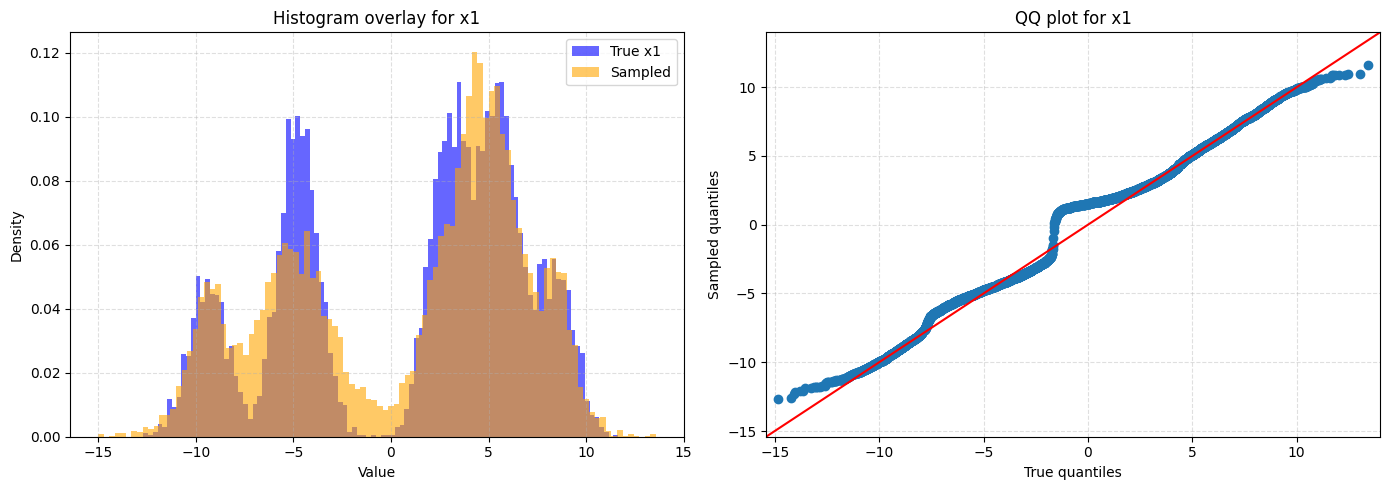

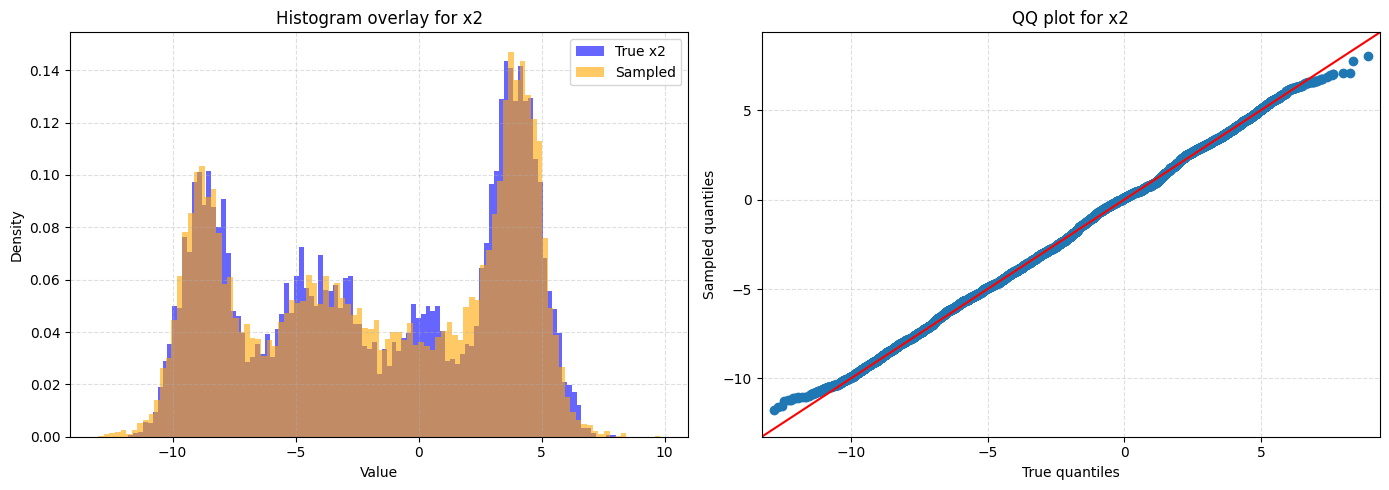

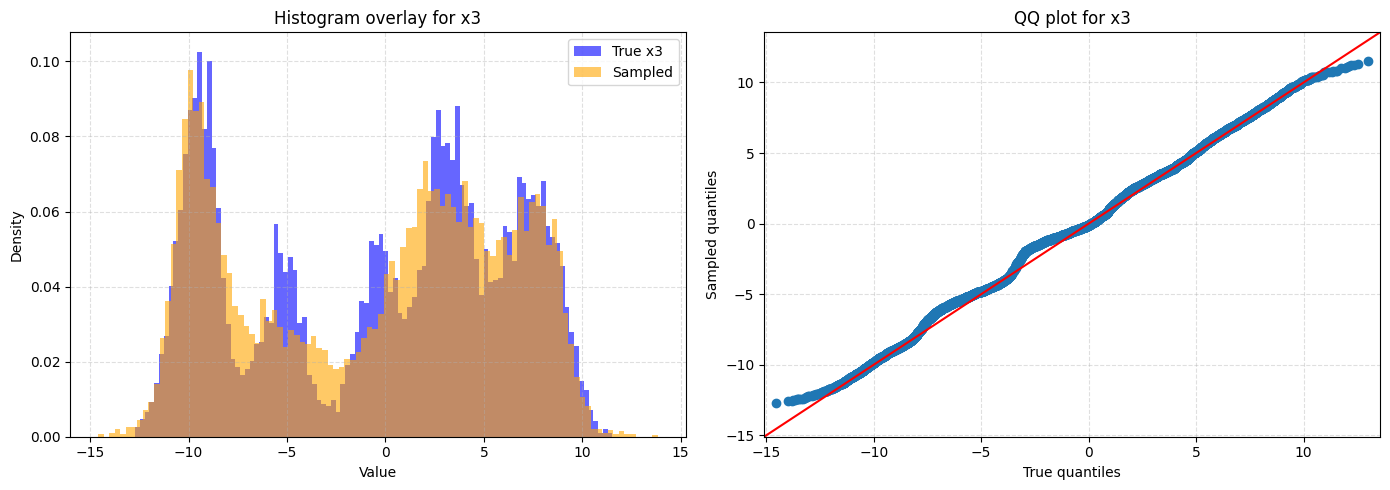

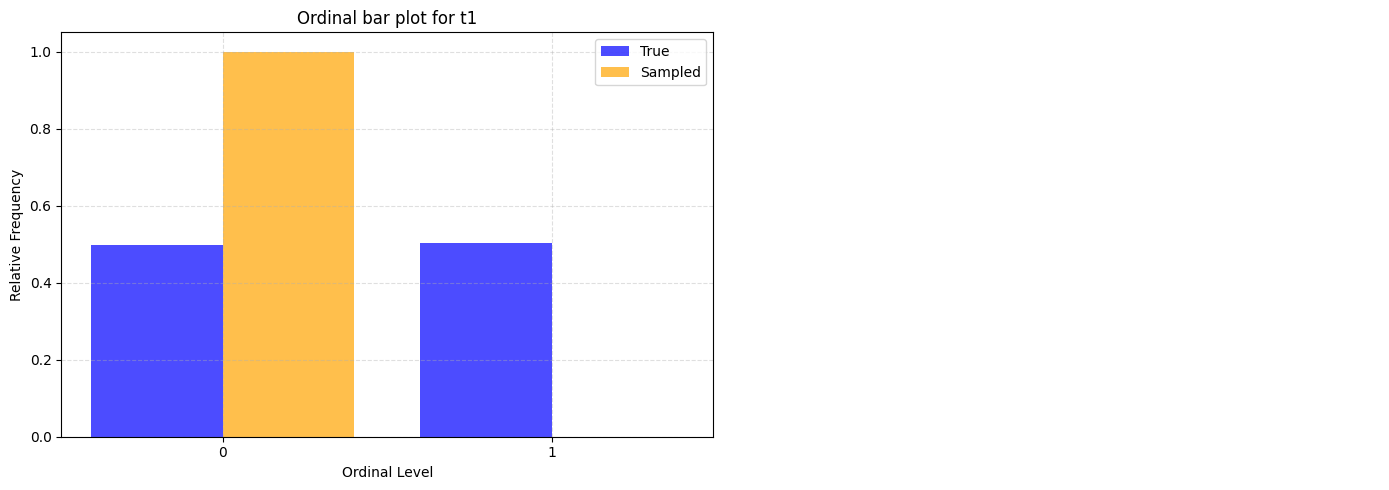

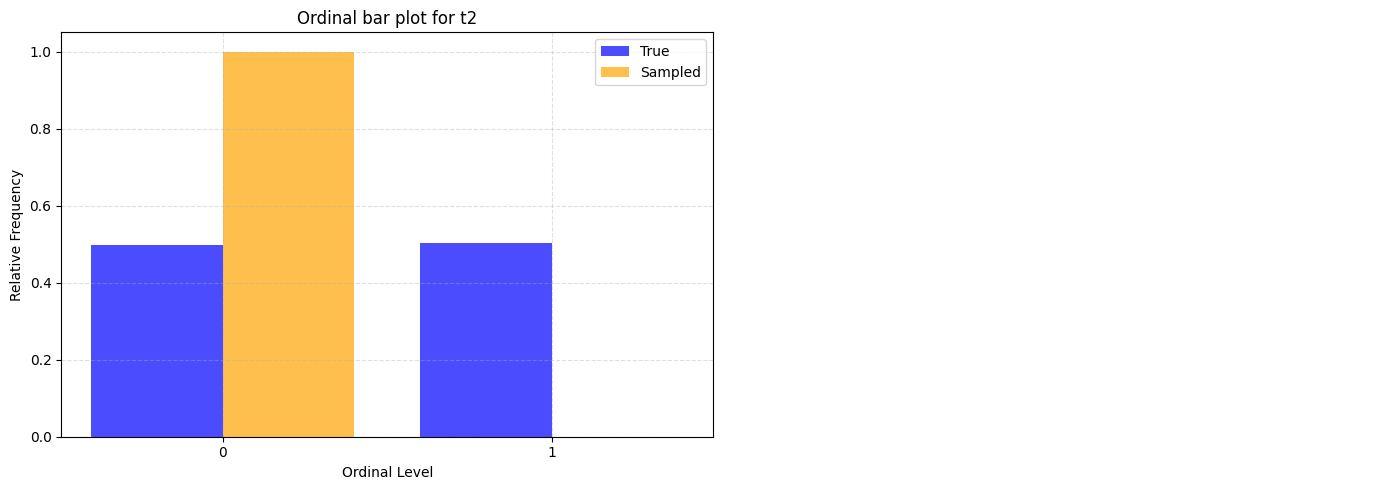

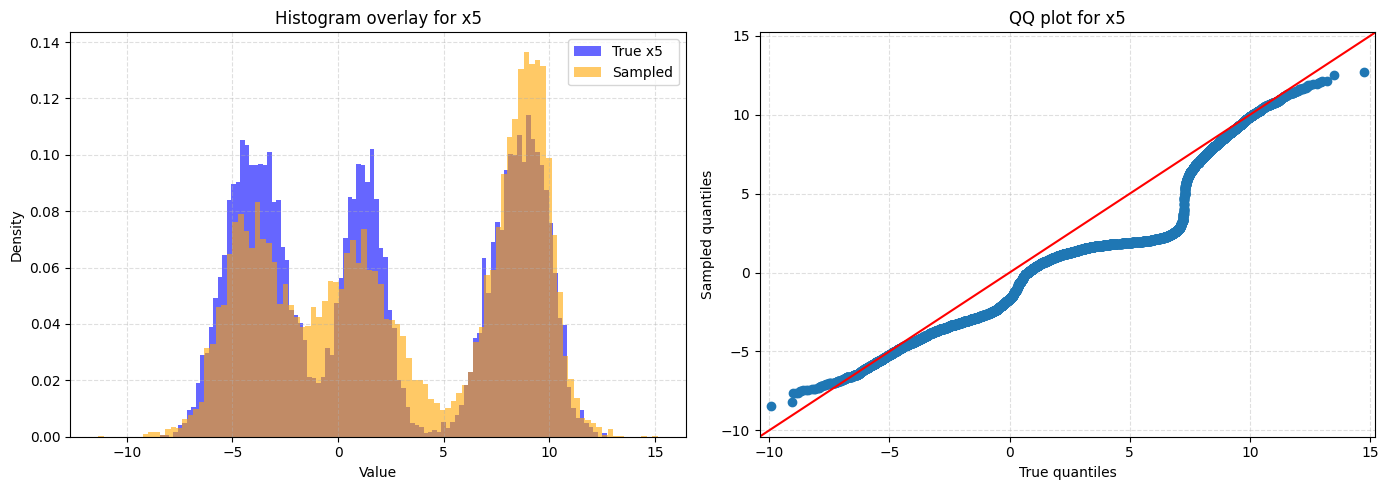

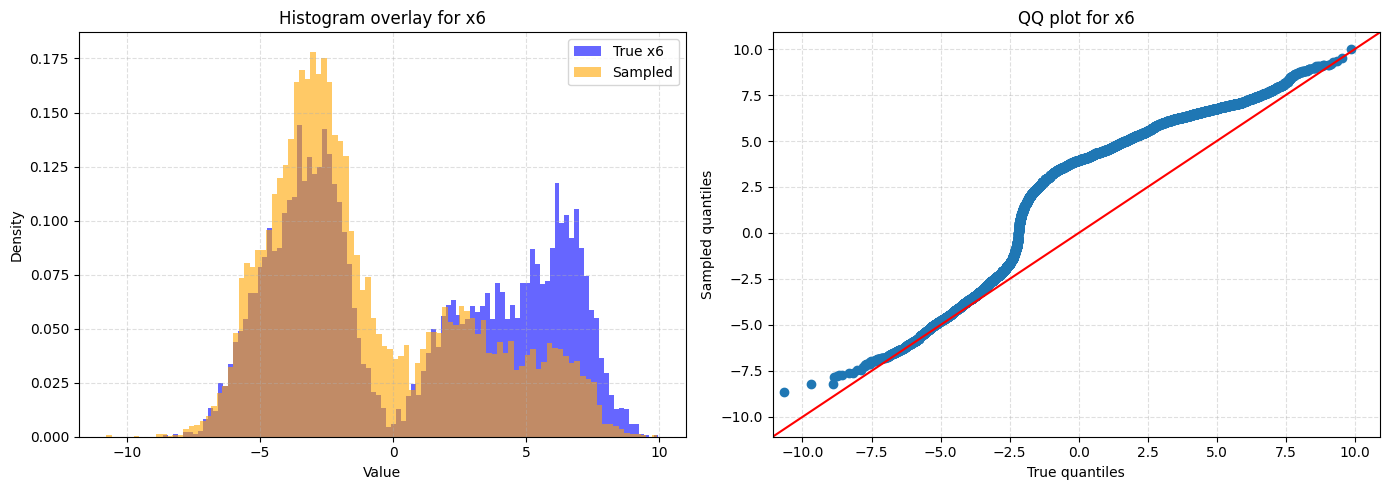

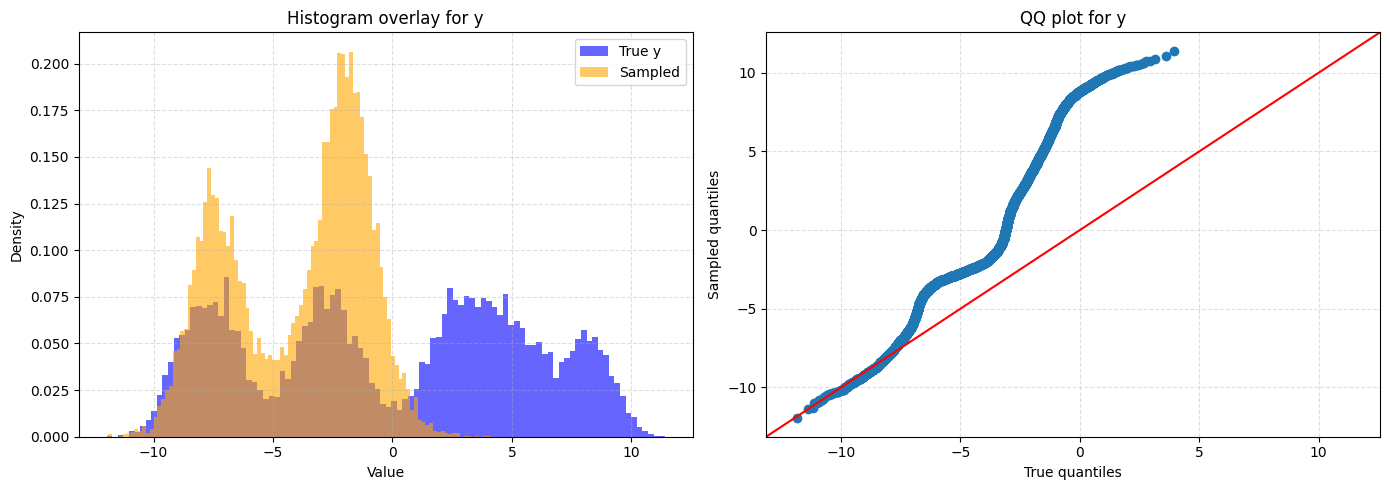

In [15]:
td_model.show_samples_vs_true(train_df)